<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "11E"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/11E/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


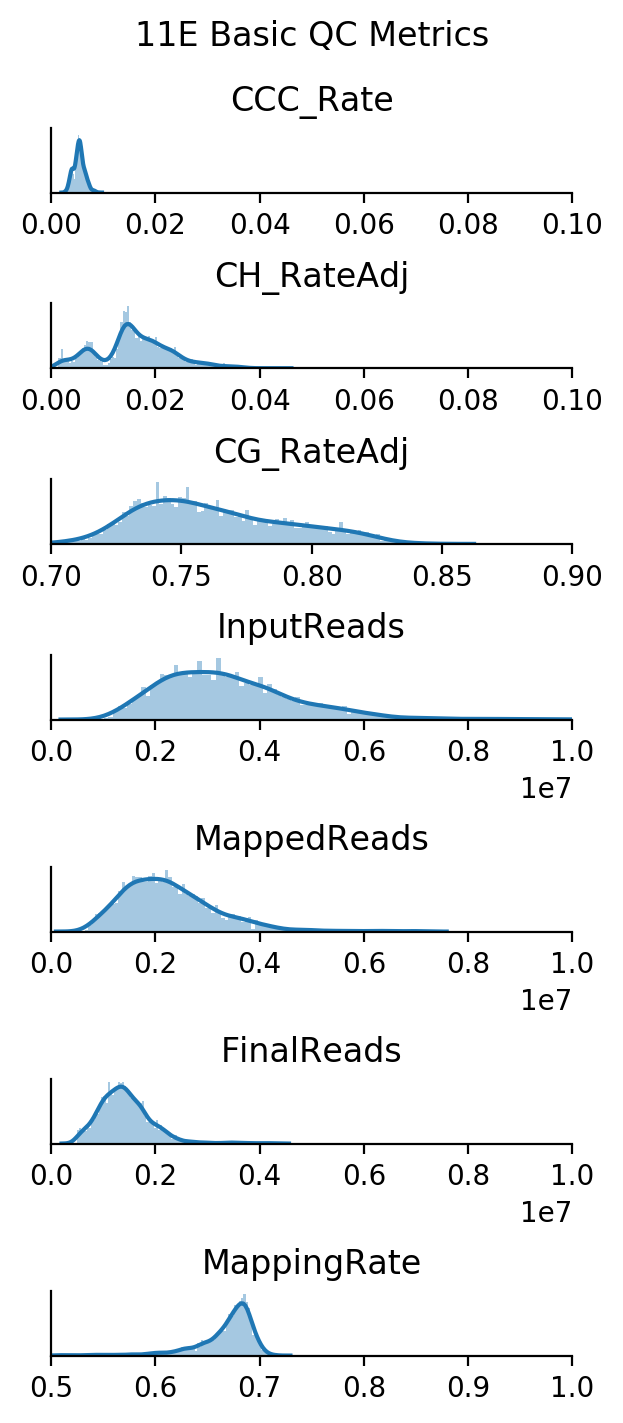

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

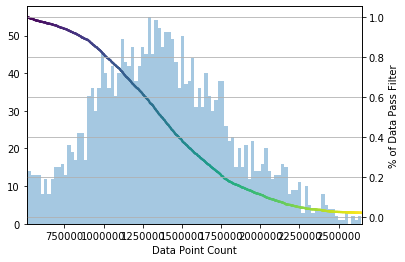

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2437/2437 (100.0%)
CG_RateAdj passed 2437/2437 (100.0%)
CH_RateAdj passed 2437/2437 (100.0%)
FinalReads passed 2437/2437 (100.0%)
MappingRate passed 2437/2437 (100.0%)
Overall passed 2437/2437 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
190214 1224
190305 1213


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 282 73.4%
ad002 320 83.3%
ad004 321 83.6%
ad006 308 80.2%
ad007 297 77.3%
ad008 289 75.3%
ad010 307 79.9%
ad012 313 81.5%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
11E_M_0,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.004851,0.729076,0.727755,0.018904,0.014121,1756463.0,4323336,2954478.0,11E,...,1.815138,-18.545904,-27.205074,12.527231,CA1 Chrm3,2.082154,-0.584099,9.723372,-1.571577,True
11E_M_1,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.006452,0.757862,0.756290,0.026518,0.020196,2603821.0,6502240,4531314.0,11E,...,-4.992211,-5.977819,17.655566,-3.546293,CA3 Cadm2,8.561141,-0.501037,24.699767,15.393379,True
11E_M_10,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.005425,0.748240,0.746866,0.020421,0.015077,1227862.0,2861914,1851256.0,11E,...,0.595367,-17.439999,-8.188110,-18.059355,CA1 Chrm3,1.432226,0.915821,17.179523,4.885732,True
11E_M_100,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.006043,0.791108,0.789838,0.026546,0.020628,1840099.0,4574010,3116666.0,11E,...,8.417069,8.858660,50.122727,18.170745,PT-L5 Tenm2,-17.071758,7.685368,-16.994421,2.880124,True
11E_M_1000,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.007266,0.805048,0.803621,0.035905,0.028849,1424747.0,3952158,2701779.0,11E,...,-29.569689,2.652097,-13.277179,-25.652513,MGE-Pvalb Gfra2,1.156321,-14.534151,-12.801297,13.979065,True
11E_M_1001,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.006837,0.772807,0.771243,0.030733,0.024060,612298.0,1665930,1006975.0,11E,...,-7.270119,-14.720533,56.632488,-6.046361,DG-po Calb2,9.203941,3.836549,1.765306,-0.529188,True
11E_M_1002,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.005556,0.793765,0.792612,0.023349,0.017892,1670316.0,3968640,2729242.0,11E,...,-0.383624,-11.942327,0.967506,3.167700,CA1 Ak5,6.648650,6.532006,18.460217,34.355038,True
11E_M_1003,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.003987,0.732873,0.731804,0.010893,0.006934,1578120.0,3698922,2545617.0,11E,...,-13.659375,-12.526060,-12.622202,28.468284,DG dg-all,5.131914,-2.780144,-18.977967,-27.750645,True
11E_M_1005,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.008032,0.805696,0.804123,0.041568,0.033807,1525192.0,3615180,2505073.0,11E,...,-29.765347,2.991127,-12.919308,-26.007589,MGE-Pvalb Gfra2,0.436301,-14.441669,-12.067044,15.276632,True
11E_M_1006,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.005380,0.728303,0.726834,0.018628,0.013319,1383085.0,3442962,2245032.0,11E,...,4.634159,-17.817926,-12.394897,11.768838,CA1 Ptprg,-1.860378,1.248424,22.474113,-18.116567,True
